In [19]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from scraping import get_element_from_selector, get_info_from_job, get_page_of_attributes, scrape_ds, scrape_glassdoor_url, css_mappings
#from clean_salaries import filter_jobs_with_salaries, create_salaries_cols
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
import pandas as pd
blacklisted_occupations = ['physician', 'dentist', 'psychiatrist', 'pediatrician', 'oncologist', 'crna', 'surgeon', 'anesthesiologist', 'neurologist', 'hospitalist']

def filter_jobs_with_salaries(df,salary_col):
    #must have salary range
    tempdf=df[df[salary_col].notnull()]
    #must not be hourly, shortcut look for 'K'
    tempdf=tempdf[tempdf['salary_range'].str.find('K')>0]
    tempdf=tempdf[tempdf['salary_range'].str.find('Employer Provided Salary:')<0]
    return tempdf
def create_salaries_cols(df,salary_col):
    '''
    parses salary range column, removes formatting, and splits to upper, lower bounds, and salary estimate type
    returns dataframe with cleansed salary format
    '''
    tempdf = df['salary_range'].str.replace('$','')
    tempdf = tempdf.str.split('K', expand=True)
    tempdf.columns = ['salary_lower','salary_upper','salary_estimator']
    tempdf['salary_upper'] = tempdf['salary_upper'].str.replace('-','')
    numeric_cols = ['salary_lower','salary_upper']
    tempdf[numeric_cols]=tempdf[numeric_cols].apply(pd.to_numeric)
    df=pd.concat([df,tempdf],axis=1)
    df=df.drop(columns=[salary_col])
    return df

def convert_salaries_hourly(df,salary_col):
    hourly=df[df['salary_range'].str.lower().str.find('per hour')>0]['salary_range']
    hourly=hourly.str.replace('Employer Provided Salary:','')
    hourly=hourly.str.replace('Per Hour','')
    hourly=hourly.str.replace("Glassdoor Est.",'')
    hourly=hourly.str.replace("\(\)","")
    hourly=hourly.str.replace('$','')
    hourly=hourly.str.split('-',expand=True)
    hourly.columns=['salary_lower','salary_upper']
    numeric_cols = ['salary_lower','salary_upper']
    hourly[numeric_cols]=hourly[numeric_cols].apply(pd.to_numeric)
    return df

In [14]:
dfds=pd.read_csv('/Users/michaelpalmer/galvanize/level-up/ds_30.csv', sep='|')

In [15]:
dfds.drop(columns='Unnamed: 0', inplace=True)

In [16]:
dfds.head()

,job_title,job_description,stars,salary_range
0,Senior Data Scientist or Data Scientist,Senior Data Scientist or Data Scientist #88345...,3.1 ★,$120K-$170K (Glassdoor Est.)
1,Data Scientist - Risk,Postmates runs one of the largest marketplaces...,2.9 ★,$90K-$127K (Glassdoor Est.)
2,Data Scientist,Data Scientist\nAdColony is on a mission to ma...,2.2 ★,$120K-$169K (Glassdoor Est.)
3,Data Scientist,Smartsheet is looking for an experienced Data ...,4.6 ★,$108K-$155K (Glassdoor Est.)
4,Data Scientist,Data Scientist\n\n27-Jul-2018\n\nPosition Summ...,4.3 ★,$118K-$173K (Glassdoor Est.)


In [17]:
dfclean = filter_jobs_with_salaries(dfds,'salary_range')
dfclean = create_salaries_cols(dfclean,'salary_range')

In [21]:
dfclean.head()

,job_title,job_description,stars,salary_lower,salary_upper,salary_estimator
0,Senior Data Scientist or Data Scientist,Senior Data Scientist or Data Scientist #88345...,3.1 ★,120,170,(Glassdoor Est.)
1,Data Scientist - Risk,Postmates runs one of the largest marketplaces...,2.9 ★,90,127,(Glassdoor Est.)
2,Data Scientist,Data Scientist\nAdColony is on a mission to ma...,2.2 ★,120,169,(Glassdoor Est.)
3,Data Scientist,Smartsheet is looking for an experienced Data ...,4.6 ★,108,155,(Glassdoor Est.)
4,Data Scientist,Data Scientist\n\n27-Jul-2018\n\nPosition Summ...,4.3 ★,118,173,(Glassdoor Est.)


In [30]:
cvec=CountVectorizer(stop_words='english')
cvec.fit(dfclean['job_description'])
bag_of_words=cvec.transform(dfclean['job_description'])
sum_words = bag_of_words.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in     cvec.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
#return words_freq[:n]

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [71]:
arr=np.array(words_freq[:50])
X=arr[:,0]
y=arr[:,1]
y=y.astype(int)

Text(0.5,1,'Term Frequency in Data Science Job Postings')

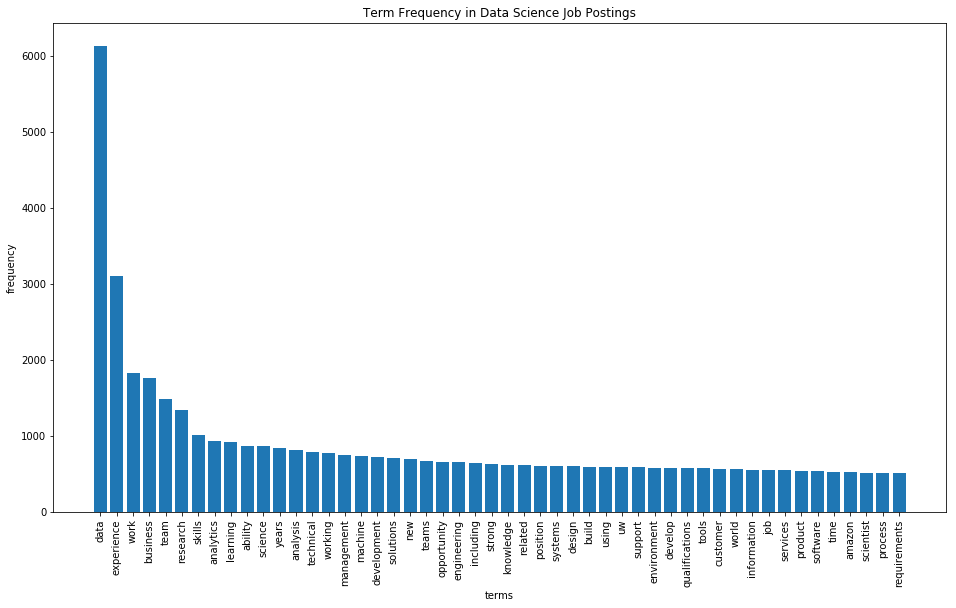

In [93]:
fig, ax = plt.subplots(figsize=(16,9))
ax.bar(X,y)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.set_xlabel('terms')
ax.set_ylabel('frequency')
ax.set_title('Term Frequency in Data Science Job Postings')

In [100]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 1), stop_words='english')

In [101]:
bag_of_words = tfidf.fit_transform(dfclean['job_description'])

/Users/michaelpalmer/anaconda/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [102]:
bag_of_words

<609x3683 sparse matrix of type '<class 'numpy.float64'>'
	with 133938 stored elements in Compressed Sparse Row format>

In [108]:
feature_array = np.array(tfidf.get_feature_names())
tfidf_sorting = np.argsort(bag_of_words.toarray()).flatten()[::-1]

n = 50
X = feature_array[tfidf_sorting][:n]
y = np.sort(bag_of_words.toarray()).flatten()[::-1]
y=y[:n]

Text(0.5,1,'TFIDF in Data Science Job Postings')

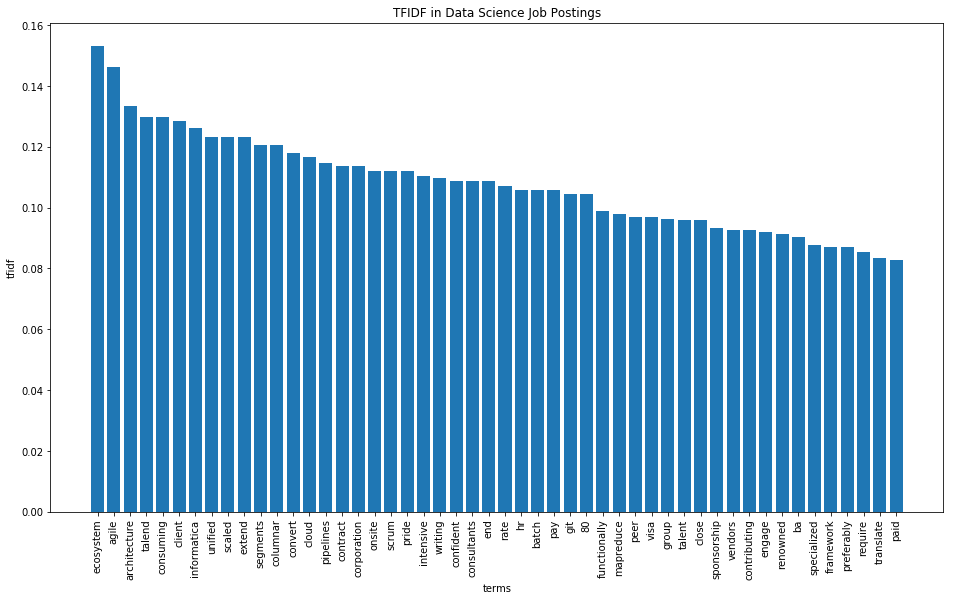

In [125]:
fig, ax = plt.subplots(figsize=(16,9))
ax.bar(X,y)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.set_xlabel('terms')
ax.set_ylabel('tfidf')
ax.set_title('TFIDF in Data Science Job Postings')

In [126]:
y.shape

(50,)

In [130]:
skills_vector = ['machine learning', 'python', 'java', 'hadoop', 'spark', 'data mining', 'r', 'c++', 'hive',
                'pig', 'sql', 'natural language processing', 'ai', 'nosql', 'image processing', 'tableau', 
                 'sas', 'matlab', 'embedded software', 'spss', 'oop', 'azure', 'javascript', 'sdlc', '.net', 
                 'perl', 'rest', 'big data', 'jenkins', 'oracle', 'management experience', 's3', 'jira', 
                 'json', 'shell scripting', 'test automation', 'clojure', 'data science', 'go', 'biotechnology',
                 'ci', 'project management', 'excel', 'microsoft office', 'docker', 'data analysis', 'postgresql',
                 'ruby', 'laboratory experience', 'kubernetes', 'microsoft powerpoint', 'program management',
                 'd3.js', 'git', 'data warehouse', 'html5', 'microsoft sql server', 'hbase', 'ansible', 
                 'google cloud platform', 'unit testing', 'node.js', 'php', 'react', 'marketing', 'spring',
                 'maven', 'signal processing', 'power bi', 'mysql', 'scripting', 'svn', 'angular', 
                 'time management', 'analysis skills', 'visual basic', 'kafka', 'molecular biology','dynamodb',
                 'system design', 'weka', 'leadership experience', 'sentiment analytics', 'mirosoft word', 'sap',
                 'software development', 'clinical research', 'mongodb', 'predictive analytics', 
                 'statistical analytics', 'genetics', 'cloud computing', 'visual studio', 'cassandra', 
                 'supply chain experience', 'erp systems']
skeelz=set(skills_vector)

In [141]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=2, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english', vocabulary=skeelz)
#tfidf.vocabulary
tfidf.fit(dfclean['job_description'])
bag_of_words = tfidf.fit_transform(dfclean['job_description'])

feature_array = np.array(tfidf.get_feature_names())
tfidf_sorting = np.argsort(bag_of_words.toarray()).flatten()[::-1]

n = 50
X = feature_array[tfidf_sorting][:n]
y = np.sort(bag_of_words.toarray()).flatten()[::-1]
y=y[:n]

/Users/michaelpalmer/anaconda/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


<609x96 sparse matrix of type '<class 'numpy.int64'>'
	with 2334 stored elements in Compressed Sparse Row format>

Text(0.5,1,'TFIDF in Data Science Job Postings')

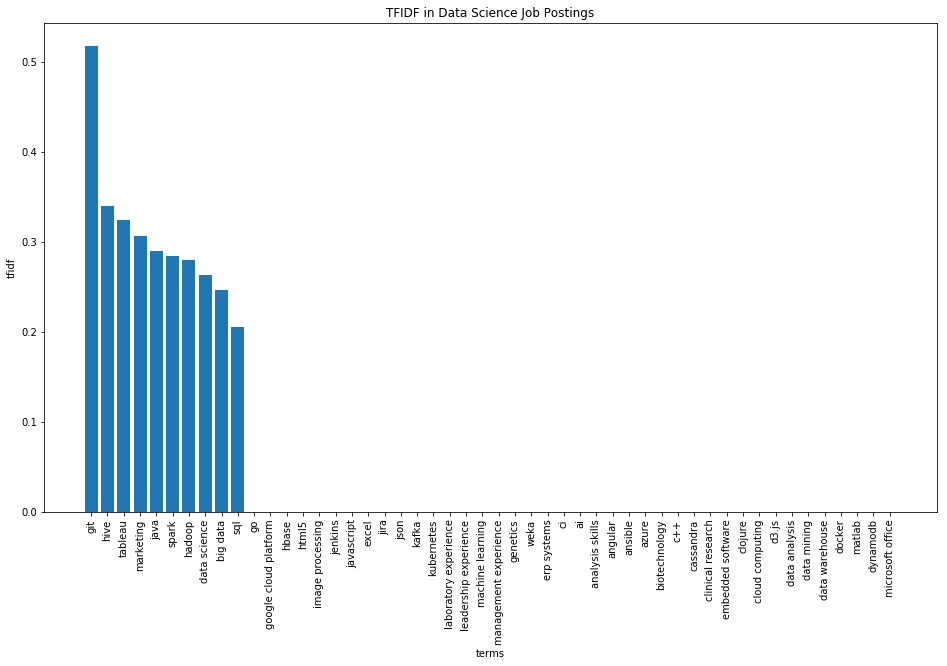

In [142]:
fig, ax = plt.subplots(figsize=(16,9))
ax.bar(X,y)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.set_xlabel('terms')
ax.set_ylabel('tfidf')
ax.set_title('TFIDF in Data Science Job Postings')

In [156]:
np.sort(bag_of_words.toarray()).flatten()[::-1].shape

(58464,)

In [207]:
cvec=CountVectorizer(stop_words='english', vocabulary=skeelz)
cvec.fit(dfclean['job_description'])
bag_of_words=cvec.transform(dfclean['job_description'])
bag_of_words_document_ind = bag_of_words>0
sum_words = bag_of_words.sum(axis=0) 
count_words = bag_of_words_document_ind.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in     cvec.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
#return words_freq[:n]

Text(0.5,1,'Document Frequency in Data Science Job Postings')

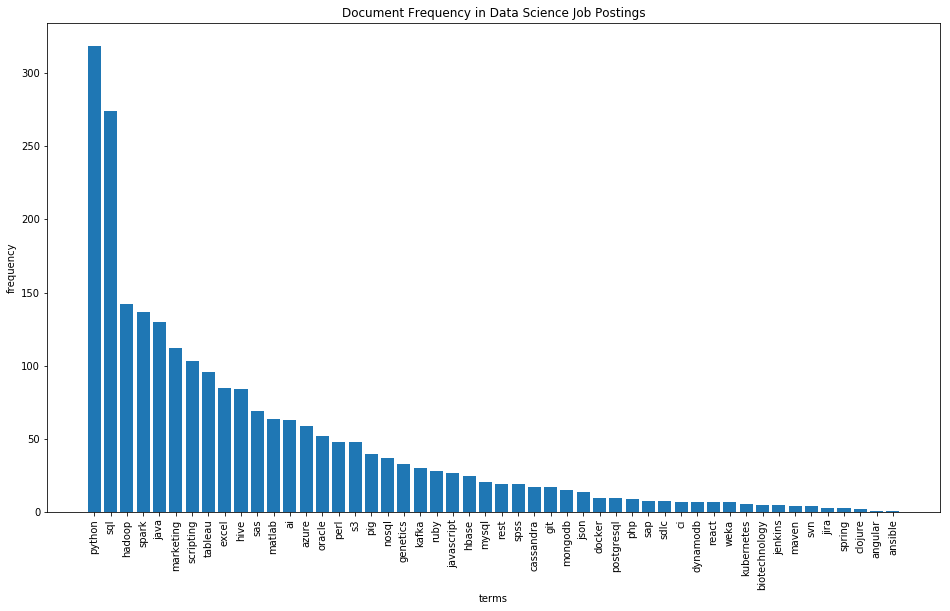

In [212]:
#bag_of_words.toarray().count()
#cvec.vocabulary_.items()
#count_words
doc_freq = [(word, count_words[0, idx]) for word, idx in     cvec.vocabulary_.items()]
doc_freq =sorted(doc_freq, key = lambda x: x[1], reverse=True)
doc_freq
arr=np.array(doc_freq[:50])
X=arr[:,0]
y=arr[:,1]
y=y.astype(int)
fig, ax = plt.subplots(figsize=(16,9))
ax.bar(X,y)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.set_xlabel('terms')
ax.set_ylabel('frequency')
ax.set_title('Document Frequency in Data Science Job Postings')

In [192]:
#bag_of_words.sum(axis=0)
#cvec.vocabulary_
np.sort(bag_of_words.count(axis=0))
np.argsort(bag_of_words.sum(axis=0)) 
bag_of_words.count(axis=0)
#[::-1]
#cvec.vocabulary_

AttributeError: count not found

Text(0.5,1,'Term Frequency in Data Science Job Postings')

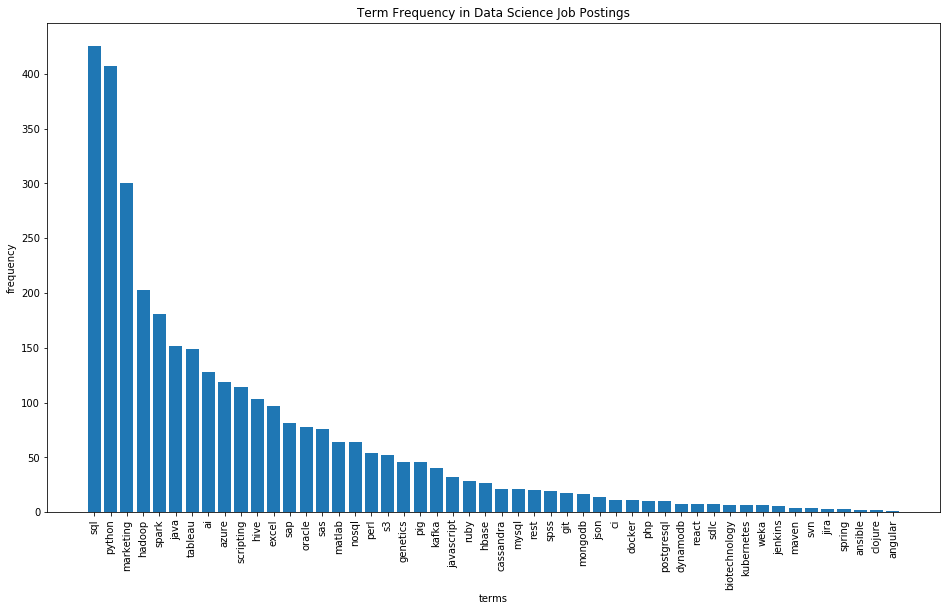

In [144]:
arr=np.array(words_freq[:50])
X=arr[:,0]
y=arr[:,1]
y=y.astype(int)
fig, ax = plt.subplots(figsize=(16,9))
ax.bar(X,y)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.set_xlabel('terms')
ax.set_ylabel('frequency')
ax.set_title('Term Frequency in Data Science Job Postings')

array([7.41345896, 3.25457587, 4.58024561, 6.72031178, 6.72031178,
       3.31911439, 2.15596359, 5.62169949, 7.41345896, 4.5230872 ,
       5.33401742, 4.01226158, 6.31484667, 3.94772305, 7.41345896,
       2.42302637, 3.05675013, 2.30147117, 3.50143595, 5.01556368,
       5.33401742, 7.41345896, 6.72031178, 2.95911166, 3.88709843,
       4.5230872 , 7.41345896, 7.41345896, 2.45061433, 4.15536242,
       2.9708077 , 7.41345896, 5.21623438, 2.53826163, 4.08125445,
       5.62169949, 6.0271646 , 4.70540876, 3.97947175, 5.46754881,
       6.72031178, 5.46754881, 1.86828151, 4.01226158, 2.68607114,
       3.23907169, 5.80402104, 4.70540876, 6.31484667, 7.41345896,
       7.41345896, 3.82994002, 4.64087023, 4.3224165 , 7.41345896,
       7.41345896, 3.7758728 , 6.72031178, 3.44316704, 3.52163866,
       5.11087386, 3.69988689, 5.01556368, 4.58024561, 3.97947175,
       5.11087386, 3.48163332, 1.64826785, 7.41345896, 5.33401742,
       4.41772668, 4.04616313, 3.52163866, 5.21623438, 3.16496